In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from model import FindBestModelOffset, Predict

sns.set_theme()

In [61]:
# load and filter the dataset to just the locale and period of interest
raw_data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', usecols=['date', 'iso_code', 'new_deaths', 'new_cases', 'new_deaths_smoothed', 'new_cases_smoothed'], parse_dates=['date'])
df = raw_data[(raw_data.iso_code == 'USA') & (raw_data.date >= np.datetime64('2020-06-24'))]
df.info()

new_cases = df[['new_cases']]
new_deaths = df['new_deaths']

new_cases_smoothed = df[['new_cases_smoothed']]
new_deaths_smoothed = df['new_deaths_smoothed']

dates = df['date']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 52122 to 52299
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   iso_code             178 non-null    object        
 1   date                 178 non-null    datetime64[ns]
 2   new_cases            178 non-null    float64       
 3   new_cases_smoothed   178 non-null    float64       
 4   new_deaths           178 non-null    float64       
 5   new_deaths_smoothed  178 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 9.7+ KB


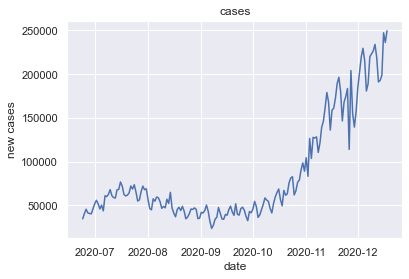

In [62]:
fig, ax = plt.subplots()
plt.title("cases") 
ax.set_xlabel("date") 
ax.set_ylabel("new cases") 
ax.plot(dates, new_cases, label="cases")

plt.show()

Text(0.5, 0.98, 'offset=28  $r^2=0.703$')

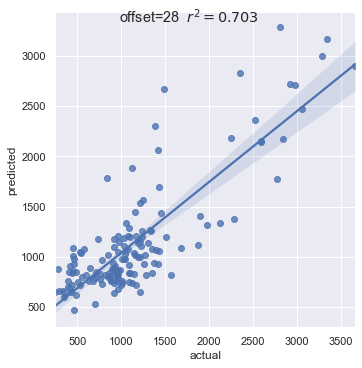

In [64]:
model, r2, predictions, actuals, offset = FindBestModelOffset(new_cases, new_deaths, 45)

fig = sns.lmplot(data= pd.DataFrame({'predicted': predictions, 'actual': actuals}), x="actual", y="predicted").fig
fig.suptitle(rf"offset={offset}  $r^2={round(r2,3)}$")

Text(0.5, 0.98, 'actual & projected deaths')

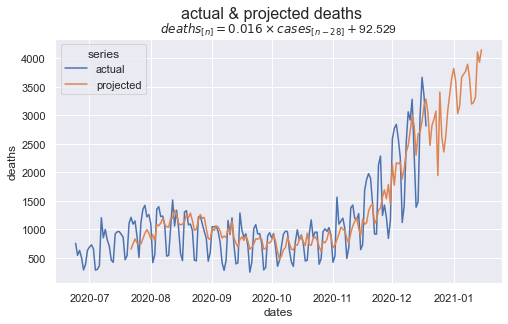

In [65]:
projected_dates, actual_deaths, projected_deaths = Predict(model, dates, new_cases, new_deaths, offset)

frame = pd.DataFrame({"dates": projected_dates.values, 
    "actual": actual_deaths.values, 
    "projected": projected_deaths.values})

data = frame.melt(id_vars=['dates'], var_name='series', value_name='deaths')

ax = sns.lineplot(data=data, x="dates", y="deaths", hue="series")
ax.set_title(fr'$deaths_{{[n]}}={round(model.coef_[0], 3)} \times cases_{{[n-{offset}]}} + ${round(model.intercept_, 3)}', fontsize=12)

fig = ax.figure
fig.set_size_inches(8, 4.5)
fig.suptitle('actual & projected deaths', fontsize=16)

Text(0.5, 0.98, 'offset=21  $r^2=0.965$')

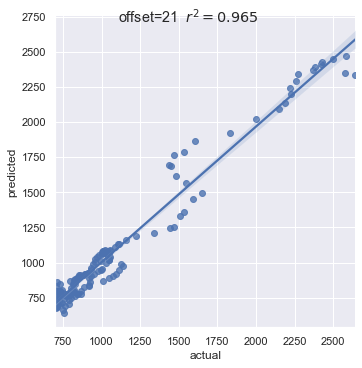

In [66]:
model, r2, predictions, actuals, offset = FindBestModelOffset(new_cases_smoothed, new_deaths_smoothed, 45)

fig = sns.lmplot(data= pd.DataFrame({'predicted': predictions, 'actual': actuals}), x="actual", y="predicted").fig
fig.suptitle(rf"offset={offset}  $r^2={round(r2,3)}$")

Text(0.5, 0.98, 'actual & projected deaths (smoothed)')

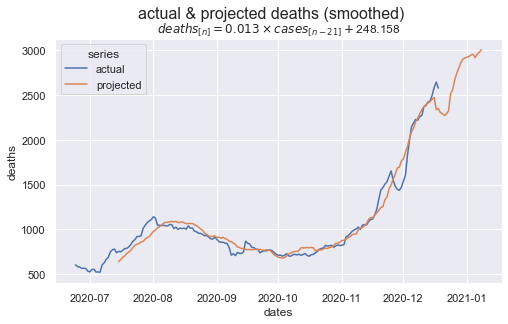

In [67]:
projected_dates, actual_deaths, projected_deaths = Predict(model, dates, new_cases_smoothed, new_deaths_smoothed, offset)

frame = pd.DataFrame({"dates": projected_dates.values, 
    "actual": actual_deaths.values, 
    "projected": projected_deaths.values})

data = frame.melt(id_vars=['dates'], var_name='series', value_name='deaths')

ax = sns.lineplot(data=data, x="dates", y="deaths", hue="series")
ax.set_title(fr'$deaths_{{[n]}}={round(model.coef_[0], 3)} \times cases_{{[n-{offset}]}} + ${round(model.intercept_, 3)}', fontsize=12)

fig = ax.figure
fig.set_size_inches(8, 4.5)
fig.suptitle('actual & projected deaths (smoothed)', fontsize=16)